<a href="https://colab.research.google.com/github/JorgeAccardi/auscultacion-presa/blob/main/Analisis_Datos_Puntos_Fijos_XLSX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paso 1: Carga de datos de Puntos Fijos desde archivo Excel (.xlsx)

Este script permite cargar los datos de puntos fijos desde un archivo Excel (.xlsx) utilizando varias fuentes posibles:

1. **Desde tu PC:** Sube el archivo manualmente.
2. **Desde Google Drive:** Especifica la ruta en tu Drive.
3. **Desde la carpeta local de Colab (`/content`):** Si el archivo ya está en el entorno de Colab.
4. **Desde un repositorio público de GitHub:** Mediante una URL directa al archivo `.xlsx`.

## Instrucciones

- Ejecuta el código y selecciona el origen de tus datos en el widget interactivo.
- Si seleccionas "PC", se abrirá un cuadro de diálogo para subir tu archivo.
- Si seleccionas "Drive", asegúrate de montar tu Google Drive y especificar la ruta al archivo.
- Si seleccionas "Local", asegúrate de que el archivo esté en `/content` (puedes subirlo previamente).
- Si seleccionas "GitHub", coloca la URL directa al archivo Excel en un repositorio público.

El DataFrame cargado se muestra en pantalla junto con información básica del archivo.

In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# Widget para seleccionar origen
origen_widget = widgets.Dropdown(
    options=['PC', 'Drive', 'Local', 'GitHub'],
    value='PC',
    description='Origen del archivo:',
    style={'description_width': 'initial'}
)

ruta_drive_widget = widgets.Text(
    value='',
    placeholder='Escribe la ruta completa en tu Google Drive',
    description='Ruta Drive:',
    disabled=False
)

ruta_local_widget = widgets.Text(
    value='',
    placeholder='Escribe el nombre del archivo en /content',
    description='Archivo Local:',
    disabled=False
)

url_github_widget = widgets.Text(
    value='',
    placeholder='Pega la URL directa al archivo .xlsx en GitHub',
    description='URL GitHub:',
    disabled=False
)

output = widgets.Output()

def cargar_datos(origen):
    df_local = None
    nombre_archivo = ""
    if origen == 'PC':
        from google.colab import files
        uploaded = files.upload()
        if not uploaded:
            print("No se seleccionó ningún archivo.")
            return
        nombre_archivo = list(uploaded.keys())[0]
        if not nombre_archivo.lower().endswith('.xlsx'):
            print("Por favor, sube un archivo .xlsx válido.")
            return
        df_local = pd.read_excel(nombre_archivo)
    elif origen == 'Drive':
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        ruta = ruta_drive_widget.value
        if not ruta or not os.path.exists(ruta):
            print("Especifica una ruta válida en tu Google Drive.")
            return
        nombre_archivo = os.path.basename(ruta)
        df_local = pd.read_excel(ruta)
    elif origen == 'Local':
        ruta = ruta_local_widget.value
        if not ruta or not os.path.exists(ruta):
            print("Especifica un archivo válido en /content.")
            return
        nombre_archivo = os.path.basename(ruta)
        df_local = pd.read_excel(ruta)
    elif origen == 'GitHub':
        url = url_github_widget.value
        if not url.lower().endswith('.xlsx'):
            print("Debes proporcionar una URL directa a un archivo .xlsx en GitHub.")
            return
        nombre_archivo = url.split("/")[-1]
        df_local = pd.read_excel(url)
    else:
        print("Origen no válido.")
        return

    # Hacer que 'df' esté disponible globalmente
    globals()['df'] = df_local

    print(f"Archivo cargado: {nombre_archivo}")
    print(df_local.shape)
    display(df_local.head())
    return df_local

def mostrar_widgets_de_origen(change):
    clear_output(wait=True)
    display(origen_widget)
    if origen_widget.value == 'Drive':
        display(ruta_drive_widget)
    elif origen_widget.value == 'Local':
        display(ruta_local_widget)
    elif origen_widget.value == 'GitHub':
        display(url_github_widget)
    display(boton_cargar)
    display(output)

def boton_cargar_click(b):
    output.clear_output()
    with output:
        cargar_datos(origen_widget.value)

# Botón para ejecutar la carga
boton_cargar = widgets.Button(description="Cargar archivo")
boton_cargar.on_click(boton_cargar_click)

origen_widget.observe(mostrar_widgets_de_origen, names='value')

# Mostrar widgets iniciales
display(origen_widget)
display(boton_cargar)
display(output)
mostrar_widgets_de_origen(None)

Dropdown(description='Origen del archivo:', options=('PC', 'Drive', 'Local', 'GitHub'), style=DescriptionStyle…

Button(description='Cargar archivo', style=ButtonStyle())

Output()

# Paso 2: Limpieza y preprocesamiento de datos (archivo Excel)

Este paso toma el DataFrame cargado desde el archivo Excel (.xlsx) y realiza una limpieza y preprocesamiento básico para preparar los datos para el análisis:

1. **Uniformiza los nombres de las columnas:**  
   Convierte todos los nombres de las columnas a mayúsculas y reemplaza los espacios por guiones bajos (`_`).

2. **Convierte la columna de fecha a tipo datetime:**  
   Busca automáticamente la columna que contiene "FECHA" en su nombre y la convierte a tipo fecha.

3. **Elimina filas vacías y duplicadas:**  
   Borra filas completamente vacías y registros duplicados.

4. **Convierte columnas numéricas:**  
   Intenta convertir todas las columnas (excepto la de fecha) a tipo numérico cuando sea posible.

5. **Muestra el resultado:**  
   Presenta el tamaño del DataFrame resultante, una vista previa, los tipos de datos y el conteo de valores nulos por columna.

> Al final de este paso tendrás tus datos uniformizados, limpios y listos para el análisis exploratorio.

In [2]:
import pandas as pd
import numpy as np

try:
    df
except NameError:
    print("❌ La variable 'df' no está definida. Por favor, ejecuta primero la celda de carga de datos y asegúrate de que el DataFrame se llame 'df'.")
else:
    # --- 1. Uniformizar nombres de columnas (mayúsculas y _ en vez de espacios) ---
    df.columns = [col.strip().upper().replace(" ", "_") for col in df.columns]

    # --- 2. Detectar y convertir columnas de fechas ---
    columna_fecha = None
    for col in df.columns:
        if "FECHA" in col:
            columna_fecha = col
            break

    if columna_fecha:
        df[columna_fecha] = pd.to_datetime(df[columna_fecha], errors='coerce', dayfirst=True)

    # --- 3. Eliminar filas completamente vacías y duplicadas ---
    df = df.dropna(how='all')
    df = df.drop_duplicates()

    # --- 4. Convertir columnas numéricas a tipo numérico cuando sea posible ---
    for col in df.columns:
        if col != columna_fecha:
            df[col] = pd.to_numeric(df[col], errors='ignore')

    # --- 5. Vista rápida del resultado ---
    print("Shape luego de limpieza:", df.shape)
    display(df.head())
    print(df.dtypes)
    print(df.isnull().sum())

Shape luego de limpieza: (3952, 13)


<ipython-input-2-4055849531>:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


FECHA   MARGEN INSTRUMENTO  DELTA_NORTE_[M]  DELTA_ESTE_[M]  \
0 2021-10-04  Derecha  PF01 PRIMA         0.000333       -0.000667   
1 2021-10-10  Derecha  PF01 PRIMA        -0.000667       -0.000667   
2 2021-10-14  Derecha  PF01 PRIMA         0.003333        0.003333   
3 2021-10-18  Derecha  PF01 PRIMA         0.002333        0.002333   
4 2021-10-27  Derecha  PF01 PRIMA        -0.000667       -0.000667   

   DELTA_COTA_[M]  DISTANCIA_[M]  DISTANCIA_(MM)  AZIMUT_REF._AL_NORTE  \
0        0.003333       0.000745        0.745356            296.565051   
1        0.004333       0.000943        0.942809            225.000000   
2        0.003333       0.004714        4.714045             45.000000   
3        0.000333       0.003300        3.299832             45.000000   
4        0.005333       0.000943        0.942809            225.000000   

   TASA_NORTE_(MM/DIA)  TASA_ESTE_(MM/DIA)  TASA_COTA_(MM/DIA)  \
0             0.041667           -0.083333            0.416667   
1            -0.047619           -0.047619            0.309524   
2             0.185185            0.185185            0.185185   
3             0.106061            0.106061            0.015152   
4            -0.021505           -0.021505            0.172043   

   TASA_DISTANCIA_(MM/DIA)  
0                 0.093169  
1                 0.067344  
2                 0.261891  
3                 0.149992  
4                 0.030413

FECHA                      datetime64[ns]
MARGEN                             object
INSTRUMENTO                        object
DELTA_NORTE_[M]                   float64
DELTA_ESTE_[M]                    float64
DELTA_COTA_[M]                    float64
DISTANCIA_[M]                     float64
DISTANCIA_(MM)                    float64
AZIMUT_REF._AL_NORTE              float64
TASA_NORTE_(MM/DIA)               float64
TASA_ESTE_(MM/DIA)                float64
TASA_COTA_(MM/DIA)                float64
TASA_DISTANCIA_(MM/DIA)           float64
dtype: object
FECHA                         0
MARGEN                        0
INSTRUMENTO                   0
DELTA_NORTE_[M]            1306
DELTA_ESTE_[M]             1306
DELTA_COTA_[M]             1306
DISTANCIA_[M]              1306
DISTANCIA_(MM)             1429
AZIMUT_REF._AL_NORTE       1329
TASA_NORTE_(MM/DIA)        1306
TASA_ESTE_(MM/DIA)         1306
TASA_COTA_(MM/DIA)         1306
TASA_DISTANCIA_(MM/DIA)    1306
dtype: int64


# Paso 3: Análisis exploratorio de datos (EDA) - Archivo Excel

En este paso se realiza un Análisis Exploratorio de Datos (EDA) sobre el DataFrame limpio proveniente del archivo Excel. El objetivo es obtener una visión general de los datos, detectar patrones, distribuciones, valores atípicos y posibles problemas antes de avanzar al análisis estadístico o modelado.

## Incluye:

1. **Resumen general del DataFrame**  
   - Número de filas y columnas.
   - Tipos de datos por columna.
   - Conteo de valores nulos por columna.

2. **Estadísticas descriptivas**
   - Estadísticas básicas de las columnas numéricas: media, desviación estándar, mínimo, máximo, percentiles, etc.
   - Estadísticas de columnas categóricas: conteo de valores únicos y frecuencia de las categorías principales.

3. **Visualización rápida**
   - Histogramas para variables numéricas.
   - Gráficos de barras para variables categóricas relevantes.
   - Boxplots para detectar valores atípicos en variables numéricas principales.

> Este paso es fundamental para familiarizarte con la estructura y calidad de los datos, y para definir estrategias de análisis posteriores.

=== Resumen general ===
Filas: 3952, Columnas: 13

Tipos de datos:
FECHA                      datetime64[ns]
MARGEN                             object
INSTRUMENTO                        object
DELTA_NORTE_[M]                   float64
DELTA_ESTE_[M]                    float64
DELTA_COTA_[M]                    float64
DISTANCIA_[M]                     float64
DISTANCIA_(MM)                    float64
AZIMUT_REF._AL_NORTE              float64
TASA_NORTE_(MM/DIA)               float64
TASA_ESTE_(MM/DIA)                float64
TASA_COTA_(MM/DIA)                float64
TASA_DISTANCIA_(MM/DIA)           float64
dtype: object

Valores nulos por columna:
FECHA                         0
MARGEN                        0
INSTRUMENTO                   0
DELTA_NORTE_[M]            1306
DELTA_ESTE_[M]             1306
DELTA_COTA_[M]             1306
DISTANCIA_[M]              1306
DISTANCIA_(MM)             1429
AZIMUT_REF._AL_NORTE       1329
TASA_NORTE_(MM/DIA)        1306
TASA_ESTE_(MM/DIA)       

FECHA  DELTA_NORTE_[M]  DELTA_ESTE_[M]  \
count                           3952      2646.000000     2646.000000   
mean   2022-11-12 05:29:01.700404736         0.002644       -0.002213   
min              2021-10-04 00:00:00        -0.037900       -0.031667   
25%              2022-04-03 18:00:00        -0.001667       -0.005000   
50%              2022-08-16 00:00:00         0.000100        0.000000   
75%              2023-05-31 00:00:00         0.006100        0.000333   
max              2026-01-10 00:00:00         0.079000        0.051000   
std                              NaN         0.012049        0.007113   

       DELTA_COTA_[M]  DISTANCIA_[M]  DISTANCIA_(MM)  AZIMUT_REF._AL_NORTE  \
count     2646.000000    2646.000000     2523.000000           2623.000000   
mean        -0.004197       0.009622        9.854053            231.147873   
min         -0.076333       0.000000        0.000000              0.000000   
25%         -0.008000       0.000100        0.100000            140.283620   
50%          0.000000       0.006396        6.655741            258.384330   
75%          0.000667       0.015628       15.990428            360.000000   
max          0.028333       0.083000       83.000000            360.000000   
std          0.011733       0.010728       10.810138            124.985566   

       TASA_NORTE_(MM/DIA)  TASA_ESTE_(MM/DIA)  TASA_COTA_(MM/DIA)  \
count          2646.000000         2646.000000         2646.000000   
mean             -0.000464            0.000788           -0.001052   
min              -0.612500           -0.875000           -0.928571   
25%              -0.000299           -0.000399           -0.000615   
50%               0.000239            0.000000            0.000000   
75%               0.001229            0.000028            0.000067   
max               0.928571            0.750000            0.928571   
std               0.054523            0.056359            0.098408   

       TASA_DISTANCIA_(MM/DIA)  
count              2646.000000  
mean                  0.029621  
min                   0.000000  
25%                   0.000346  
50%                   0.000719  
75%                   0.034995  
max                   0.952976  
std                   0.072610


=== Estadísticas descriptivas (categóricas) ===

Columna: MARGEN
MARGEN
Derecha    3952
Name: count, dtype: int64

Columna: INSTRUMENTO
INSTRUMENTO
PF45      108
PF51      108
PF04       70
PF05       70
PF07       70
Name: count, dtype: int64

=== Visualización rápida ===


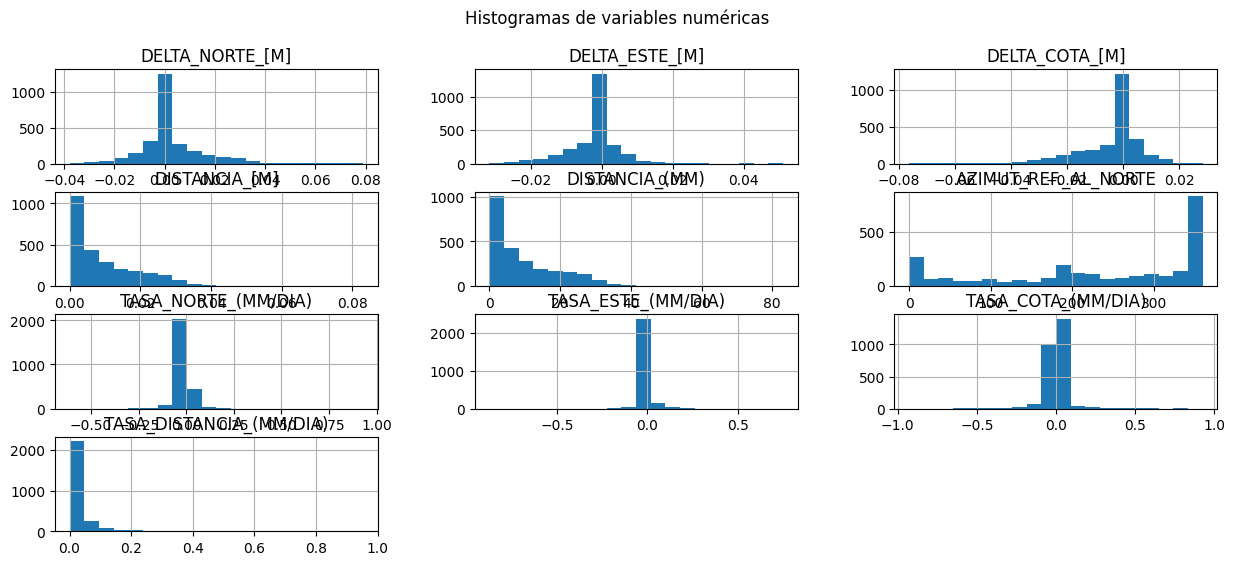

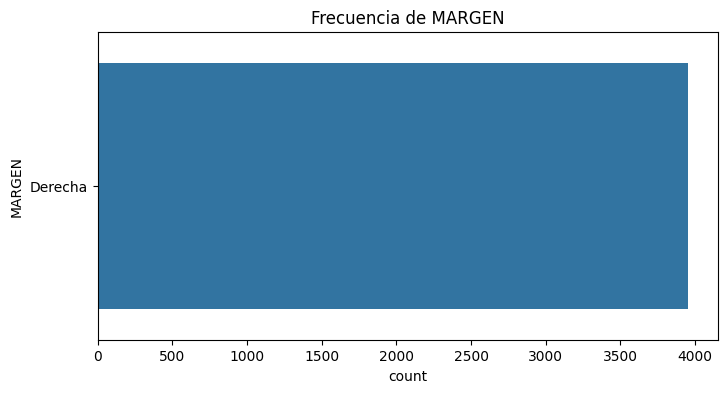

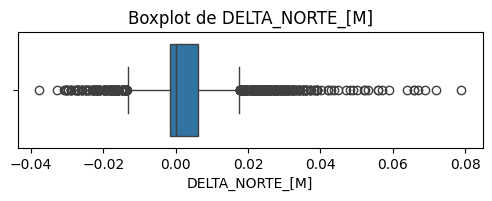

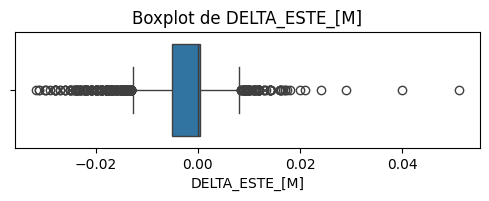

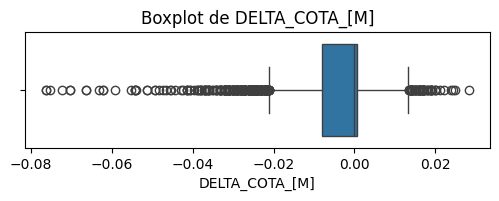

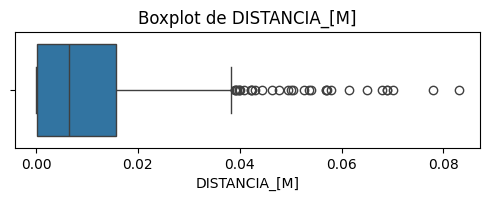

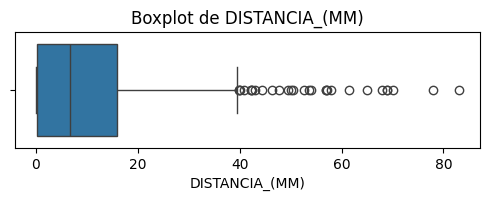

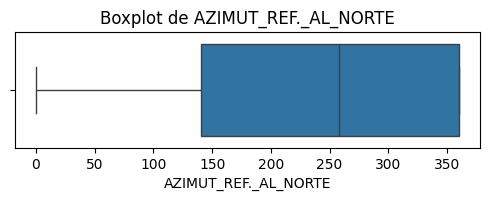

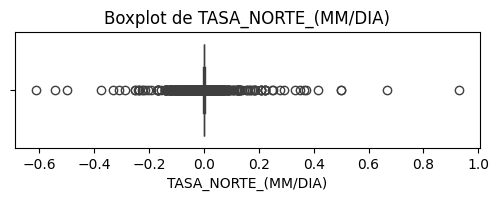

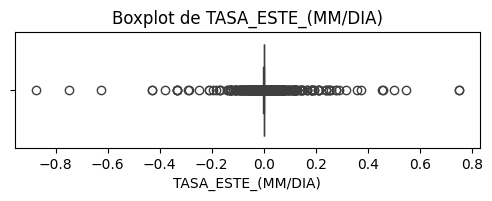

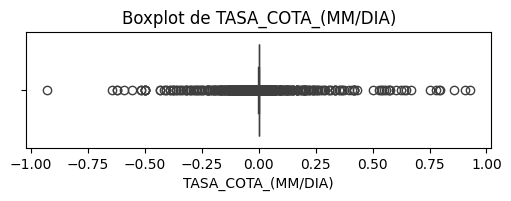

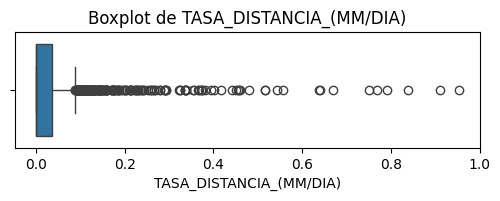

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que el DataFrame limpio se llame "df"

try:
    df
except NameError:
    print("❌ La variable 'df' no está definida. Por favor, ejecuta primero la carga y limpieza de datos.")
else:
    print("=== Resumen general ===")
    print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
    print("\nTipos de datos:")
    print(df.dtypes)
    print("\nValores nulos por columna:")
    print(df.isnull().sum())

    print("\n=== Estadísticas descriptivas (numéricas) ===")
    display(df.describe())

    # Estadísticas para variables categóricas
    print("\n=== Estadísticas descriptivas (categóricas) ===")
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        print(f"\nColumna: {col}")
        print(df[col].value_counts(dropna=False).head())

    # Visualización rápida
    print("\n=== Visualización rápida ===")
    # Histogramas para variables numéricas
    num_cols = df.select_dtypes(include=['number']).columns
    if len(num_cols) > 0:
        df[num_cols].hist(bins=20, figsize=(15, 6))
        plt.suptitle('Histogramas de variables numéricas')
        plt.show()

    # Gráficos de barras para variables categóricas principales
    for col in cat_cols:
        if df[col].nunique() < 20:
            plt.figure(figsize=(8, 4))
            sns.countplot(data=df, y=col, order=df[col].value_counts().index)
            plt.title(f'Frecuencia de {col}')
            plt.show()

    # Boxplots para variables numéricas (opcional)
    for col in num_cols:
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
        plt.show()

# Paso 4: Validación y control de calidad de los datos (archivo Excel)

Este paso se encarga de validar y controlar la calidad de los datos del DataFrame previamente limpiado y explorado. El objetivo es detectar problemas que puedan afectar el análisis, como valores atípicos, inconsistencias, formatos erróneos o datos faltantes críticos.

## Incluye:

1. **Valores faltantes**
   - Identifica columnas con porcentaje alto de valores nulos.
   - Muestra filas con datos críticos faltantes (por ejemplo, coordenadas, fechas, identificadores).

2. **Duplicados y unicidad**
   - Revisa si existen duplicados en identificadores clave (por ejemplo, ID, nombre del punto, combinación de columnas relevantes).

3. **Consistencia de formatos**
   - Verifica formatos de fechas y columnas numéricas.
   - Valida rangos plausibles para latitud, longitud y otros campos importantes.

4. **Valores atípicos**
   - Detecta outliers en variables numéricas principales mediante boxplots y z-score.

5. **Reporte de advertencias**
   - Genera advertencias sobre problemas detectados y sugiere acciones de corrección.

> Este validador ayuda a asegurar la confiabilidad de los datos antes de cualquier análisis avanzado, modelado o visualización.

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Asegúrate de que el DataFrame limpio se llame "df"
try:
    df
except NameError:
    print("❌ La variable 'df' no está definida. Por favor, ejecuta primero la carga, limpieza y EDA de datos.")
else:
    print("=== VALIDADOR DE CALIDAD DE DATOS ===")

    # 1. Valores faltantes
    print("\n--- Valores faltantes por columna:")
    faltantes = df.isnull().mean() * 100
    print(faltantes[faltantes > 0].sort_values(ascending=False))

    # Ejemplo: mostrar filas con datos críticos faltantes (ajusta el nombre según tu caso)
    columnas_criticas = []
    for clave in ['LAT', 'LON', 'LONG', 'FECHA', 'ID']:
        columnas_criticas.extend([col for col in df.columns if clave in col])
    columnas_criticas = list(set(columnas_criticas))
    if columnas_criticas:
        print(f"\nFilas con datos críticos faltantes en: {columnas_criticas}")
        display(df[df[columnas_criticas].isnull().any(axis=1)].head())
    else:
        print("\nNo se detectaron columnas críticas predefinidas para validación de nulos.")

    # 2. Duplicados y unicidad
    if 'ID' in df.columns:
        duplicados = df.duplicated(subset=['ID'])
        print(f"\nFilas duplicadas por 'ID': {duplicados.sum()}")
        if duplicados.sum() > 0:
            display(df[duplicados])
    else:
        print("\nNo se encontró columna 'ID' para chequeo de duplicados.")

    # 3. Consistencia de formatos y rangos plausibles
    for col in df.columns:
        if "FECHA" in col:
            n_fechas_invalidas = df[col].isnull().sum()
            print(f"\nFechas inválidas en '{col}': {n_fechas_invalidas}")
        if "LAT" in col:
            lat_validas = df[col].between(-90, 90)
            print(f"Latitudes fuera de rango en '{col}': {(~lat_validas).sum()}")
        if "LON" in col or "LONG" in col:
            lon_validas = df[col].between(-180, 180)
            print(f"Longitudes fuera de rango en '{col}': {(~lon_validas).sum()}")

    # 4. Valores atípicos (outliers) en numéricas
    print("\n--- Búsqueda de outliers (z-score > 3 o < -3):")
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        zs = zscore(df[col].dropna())
        outliers = np.where(np.abs(zs) > 3)[0]
        print(f"{col}: {len(outliers)} posibles outliers")

    print("\n--- Validación completada. Revisa advertencias anteriores para posibles acciones correctivas.")

=== VALIDADOR DE CALIDAD DE DATOS ===

--- Valores faltantes por columna:
DISTANCIA_(MM)             36.158907
AZIMUT_REF._AL_NORTE       33.628543
DELTA_ESTE_[M]             33.046559
DELTA_NORTE_[M]            33.046559
DISTANCIA_[M]              33.046559
DELTA_COTA_[M]             33.046559
TASA_NORTE_(MM/DIA)        33.046559
TASA_ESTE_(MM/DIA)         33.046559
TASA_COTA_(MM/DIA)         33.046559
TASA_DISTANCIA_(MM/DIA)    33.046559
dtype: float64

Filas con datos críticos faltantes en: ['FECHA']


Empty DataFrame
Columns: [FECHA, MARGEN, INSTRUMENTO, DELTA_NORTE_[M], DELTA_ESTE_[M], DELTA_COTA_[M], DISTANCIA_[M], DISTANCIA_(MM), AZIMUT_REF._AL_NORTE, TASA_NORTE_(MM/DIA), TASA_ESTE_(MM/DIA), TASA_COTA_(MM/DIA), TASA_DISTANCIA_(MM/DIA)]
Index: []


No se encontró columna 'ID' para chequeo de duplicados.

Fechas inválidas en 'FECHA': 0

--- Búsqueda de outliers (z-score > 3 o < -3):
DELTA_NORTE_[M]: 29 posibles outliers
DELTA_ESTE_[M]: 43 posibles outliers
DELTA_COTA_[M]: 35 posibles outliers
DISTANCIA_[M]: 25 posibles outliers
DISTANCIA_(MM): 23 posibles outliers
AZIMUT_REF._AL_NORTE: 0 posibles outliers
TASA_NORTE_(MM/DIA): 51 posibles outliers
TASA_ESTE_(MM/DIA): 50 posibles outliers
TASA_COTA_(MM/DIA): 76 posibles outliers
TASA_DISTANCIA_(MM/DIA): 52 posibles outliers

--- Validación completada. Revisa advertencias anteriores para posibles acciones correctivas.


# Paso 5: Análisis estadístico avanzado (archivo Excel)

Este paso realiza un análisis estadístico más profundo sobre el DataFrame limpio. El objetivo es identificar relaciones, correlaciones, tendencias y comportamientos significativos en los datos, y sentar las bases para la modelización o la toma de decisiones.

## Incluye:

1. **Análisis de correlación**
   - Matriz de correlación entre variables numéricas.
   - Visualización con mapa de calor.

2. **Tablas de contingencia**
   - Frecuencias cruzadas entre variables categóricas seleccionadas.

3. **Comparaciones de grupos**
   - Estadísticas descriptivas agrupadas por una variable categórica relevante (si la hay).

4. **Pruebas estadísticas básicas**
   - Prueba de normalidad para variables numéricas principales.
   - Prueba de diferencia de medias entre grupos (t-test o ANOVA), si corresponde.

> Este paso permite detectar patrones y relaciones que no son evidentes a simple vista y sirve de base para análisis predictivos o de segmentación.

=== ANÁLISIS ESTADÍSTICO AVANZADO ===

Matriz de correlación:


DELTA_NORTE_[M]  DELTA_ESTE_[M]  DELTA_COTA_[M]  \
DELTA_NORTE_[M]                 1.000000        0.080825       -0.430468   
DELTA_ESTE_[M]                  0.080825        1.000000        0.424525   
DELTA_COTA_[M]                 -0.430468        0.424525        1.000000   
DISTANCIA_[M]                   0.502815       -0.297485       -0.431530   
DISTANCIA_(MM)                  0.503414       -0.289450       -0.429294   
AZIMUT_REF._AL_NORTE           -0.046655       -0.385484       -0.171481   
TASA_NORTE_(MM/DIA)             0.260174        0.047756       -0.068439   
TASA_ESTE_(MM/DIA)              0.025716        0.235855        0.044659   
TASA_COTA_(MM/DIA)             -0.032937        0.034130        0.294847   
TASA_DISTANCIA_(MM/DIA)        -0.045912        0.090794        0.076551   

                         DISTANCIA_[M]  DISTANCIA_(MM)  AZIMUT_REF._AL_NORTE  \
DELTA_NORTE_[M]               0.502815        0.503414             -0.046655   
DELTA_ESTE_[M]               -0.297485       -0.289450             -0.385484   
DELTA_COTA_[M]               -0.431530       -0.429294             -0.171481   
DISTANCIA_[M]                 1.000000        1.000000             -0.181763   
DISTANCIA_(MM)                1.000000        1.000000             -0.253830   
AZIMUT_REF._AL_NORTE         -0.181763       -0.253830              1.000000   
TASA_NORTE_(MM/DIA)           0.072917        0.074259             -0.045925   
TASA_ESTE_(MM/DIA)           -0.043446       -0.044435             -0.210548   
TASA_COTA_(MM/DIA)           -0.046424       -0.046932             -0.041262   
TASA_DISTANCIA_(MM/DIA)      -0.029059       -0.038690             -0.203934   

                         TASA_NORTE_(MM/DIA)  TASA_ESTE_(MM/DIA)  \
DELTA_NORTE_[M]                     0.260174            0.025716   
DELTA_ESTE_[M]                      0.047756            0.235855   
DELTA_COTA_[M]                     -0.068439            0.044659   
DISTANCIA_[M]                       0.072917           -0.043446   
DISTANCIA_(MM)                      0.074259           -0.044435   
AZIMUT_REF._AL_NORTE               -0.045925           -0.210548   
TASA_NORTE_(MM/DIA)                 1.000000            0.164697   
TASA_ESTE_(MM/DIA)                  0.164697            1.000000   
TASA_COTA_(MM/DIA)                  0.082723           -0.015753   
TASA_DISTANCIA_(MM/DIA)             0.047528            0.103310   

                         TASA_COTA_(MM/DIA)  TASA_DISTANCIA_(MM/DIA)  
DELTA_NORTE_[M]                   -0.032937                -0.045912  
DELTA_ESTE_[M]                     0.034130                 0.090794  
DELTA_COTA_[M]                     0.294847                 0.076551  
DISTANCIA_[M]                     -0.046424                -0.029059  
DISTANCIA_(MM)                    -0.046932                -0.038690  
AZIMUT_REF._AL_NORTE              -0.041262                -0.203934  
TASA_NORTE_(MM/DIA)                0.082723                 0.047528  
TASA_ESTE_(MM/DIA)                -0.015753                 0.103310  
TASA_COTA_(MM/DIA)                 1.000000                 0.049787  
TASA_DISTANCIA_(MM/DIA)            0.049787                 1.000000

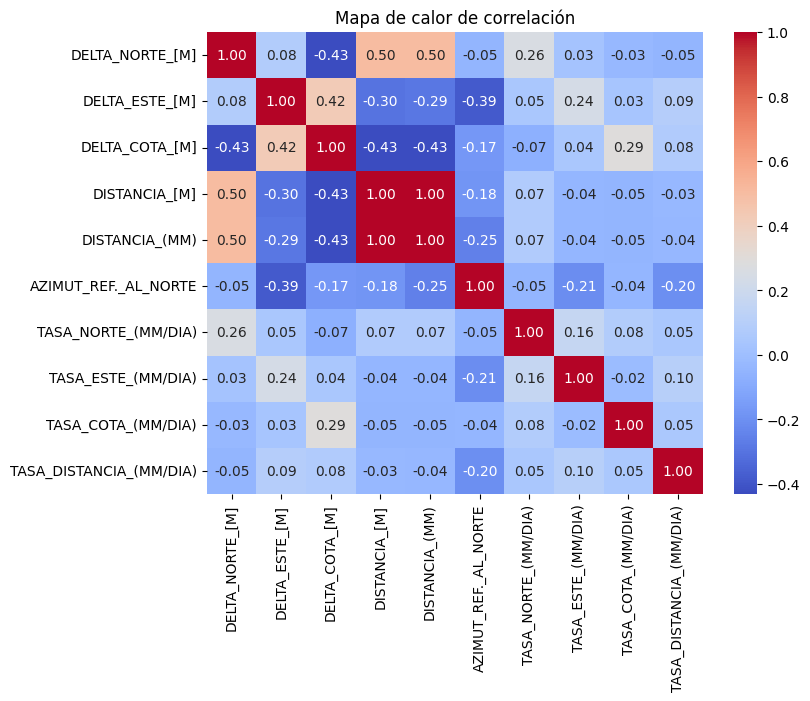


Tablas de contingencia entre variables categóricas principales:

Tabla de MARGEN vs INSTRUMENTO:


INSTRUMENTO  IN-C1  IN1-A1  IN1-B1  IN2-A1   IN2-B1  IN2-C1a   IN3-D1  IN4-B1  \
MARGEN                                                                          
Derecha         68      68      68       68      67        68      68      67   

INSTRUMENTO  IN4-D1  PF01 PRIMA  ...  PF75  PF78  PF79  PF80  PF83  PF84   \
MARGEN                           ...                                        
Derecha          67          70  ...    56    56    56    56    56     56   

INSTRUMENTO  PF85   PF87   PF89  PF90  
MARGEN                                 
Derecha         56     56    56    56  

[1 rows x 58 columns]


Estadísticas descriptivas agrupadas por 'MARGEN':


DELTA_NORTE_[M]                                                        \
                  count      mean       std     min       25%     50%     75%   
MARGEN                                                                          
Derecha          2646.0  0.002644  0.012049 -0.0379 -0.001667  0.0001  0.0061   

               DELTA_ESTE_[M]            ... TASA_COTA_(MM/DIA)            \
           max          count      mean  ...                75%       max   
MARGEN                                   ...                                
Derecha  0.079         2646.0 -0.002213  ...           0.000067  0.928571   

        TASA_DISTANCIA_(MM/DIA)                                              \
                          count      mean      std  min       25%       50%   
MARGEN                                                                        
Derecha                  2646.0  0.029621  0.07261  0.0  0.000346  0.000719   

                             
              75%       max  
MARGEN                       
Derecha  0.034995  0.952976  

[1 rows x 80 columns]


Prueba de normalidad (Shapiro-Wilk):
DELTA_NORTE_[M]: p-valor=0.0000 (no normal)
DELTA_ESTE_[M]: p-valor=0.0000 (no normal)
DELTA_COTA_[M]: p-valor=0.0000 (no normal)
DISTANCIA_[M]: p-valor=0.0000 (no normal)
DISTANCIA_(MM): p-valor=0.0000 (no normal)
AZIMUT_REF._AL_NORTE: p-valor=0.0000 (no normal)
TASA_NORTE_(MM/DIA): p-valor=0.0000 (no normal)
TASA_ESTE_(MM/DIA): p-valor=0.0000 (no normal)
TASA_COTA_(MM/DIA): p-valor=0.0000 (no normal)
TASA_DISTANCIA_(MM/DIA): p-valor=0.0000 (no normal)

--- Fin del análisis estadístico avanzado ---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Asegúrate de que el DataFrame limpio se llame "df"
try:
    df
except NameError:
    print("❌ La variable 'df' no está definida. Por favor, ejecuta primero la carga y limpieza de datos.")
else:
    print("=== ANÁLISIS ESTADÍSTICO AVANZADO ===\n")

    # 1. Matriz de correlación numérica
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 1:
        print("Matriz de correlación:")
        corr = df[num_cols].corr()
        display(corr)
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Mapa de calor de correlación")
        plt.show()
    else:
        print("No hay suficientes columnas numéricas para correlación.")

    # 2. Tablas de contingencia (para categóricas)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) >= 2:
        print("\nTablas de contingencia entre variables categóricas principales:")
        for i in range(min(2, len(cat_cols))):
            for j in range(i+1, len(cat_cols)):
                print(f"\nTabla de {cat_cols[i]} vs {cat_cols[j]}:")
                display(pd.crosstab(df[cat_cols[i]], df[cat_cols[j]]))
    else:
        print("No hay suficientes columnas categóricas para tablas de contingencia.")

    # 3. Estadísticas por grupo (si hay variable categórica relevante)
    if len(cat_cols) > 0 and len(num_cols) > 0:
        col_cat = cat_cols[0]
        print(f"\nEstadísticas descriptivas agrupadas por '{col_cat}':")
        display(df.groupby(col_cat)[num_cols].describe())
    else:
        print("No hay suficientes columnas para agrupamientos.")

    # 4. Pruebas estadísticas básicas
    print("\nPrueba de normalidad (Shapiro-Wilk):")
    for col in num_cols:
        vals = df[col].dropna()
        if len(vals) >= 3 and len(vals) <= 5000:  # Shapiro limita n<=5000
            stat, p = stats.shapiro(vals)
            print(f"{col}: p-valor={p:.4f} {'(normal)' if p>0.05 else '(no normal)'}")
        elif len(vals) > 5000:
            print(f"{col}: Demasiados datos para Shapiro (n={len(vals)}), usar KS-test.")
            stat, p = stats.kstest((vals - vals.mean())/vals.std(ddof=0), 'norm')
            print(f"    KS-test: p-valor={p:.4f} {'(normal)' if p>0.05 else '(no normal)'}")
        else:
            print(f"{col}: Insuficientes datos para test de normalidad.")

    # t-test o ANOVA para diferencia de medias si relevante
    if len(cat_cols) > 0 and len(num_cols) > 0:
        col_cat = cat_cols[0]
        for col in num_cols:
            grupos = df[col_cat].dropna().unique()
            if len(grupos) == 2:
                grupo1 = df[df[col_cat]==grupos[0]][col].dropna()
                grupo2 = df[df[col_cat]==grupos[1]][col].dropna()
                if len(grupo1)>1 and len(grupo2)>1:
                    stat, p = stats.ttest_ind(grupo1, grupo2, equal_var=False)
                    print(f"\nT-test {col} entre {grupos[0]} y {grupos[1]}: p-valor={p:.4f} {'(diferencia significativa)' if p<0.05 else '(no significativa)'}")
            elif len(grupos) > 2:
                muestras = [df[df[col_cat]==g][col].dropna() for g in grupos if len(df[df[col_cat]==g][col].dropna())>1]
                if len(muestras) >= 2:
                    stat, p = stats.f_oneway(*muestras)
                    print(f"\nANOVA {col} para grupos en {col_cat}: p-valor={p:.4f} {'(diferencia significativa)' if p<0.05 else '(no significativa)'}")
    print("\n--- Fin del análisis estadístico avanzado ---")

# Paso 6: Visualización avanzada de datos (archivo Excel)

En este paso se generan visualizaciones más sofisticadas e interactivas para profundizar en la comprensión de los datos y comunicar hallazgos de manera efectiva.

## Incluye:

1. **Gráficos interactivos**
   - Uso de bibliotecas como Plotly, Altair o ipywidgets para explorar datos dinámicamente.
   - Histogramas, cajas, gráficos de dispersión y de barras interactivos.

2. **Dashboards básicos**
   - Creación de un tablero simple con varias visualizaciones relevantes para el análisis.

3. **Visualización de relaciones**
   - Diagramas de dispersión, pares de variables, diagramas de violín, etc.
   - Visualización de correlaciones y tendencias.

4. **Personalización y exportación**
   - Personalización de títulos, etiquetas y colores.
   - Exportación de gráficos a archivos de imagen o HTML interactivo.

> Este paso es ideal para presentaciones, análisis exploratorios en profundidad y para identificar patrones que no se observan fácilmente en tablas o gráficos estáticos.

=== VISUALIZACIÓN AVANZADA DE DATOS ===



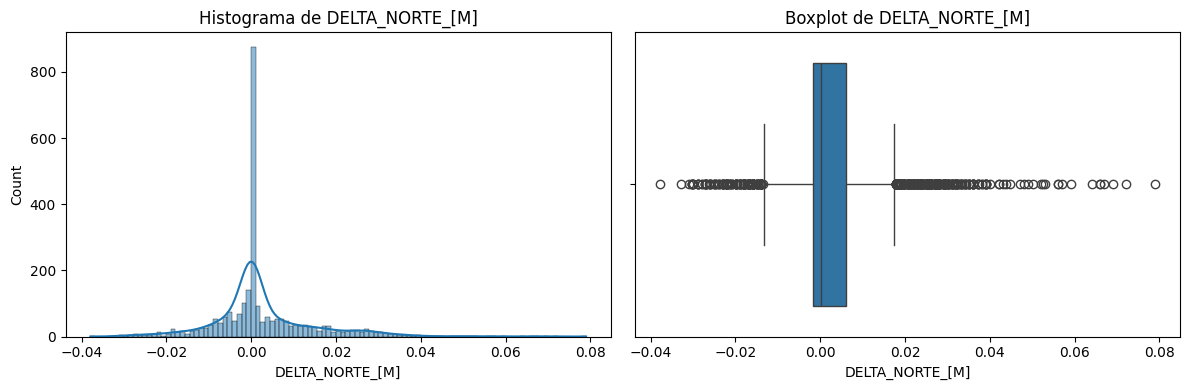

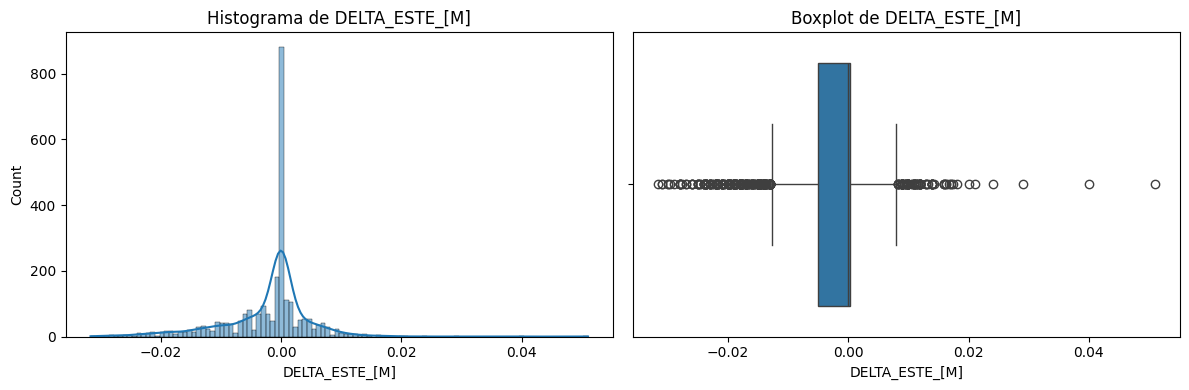

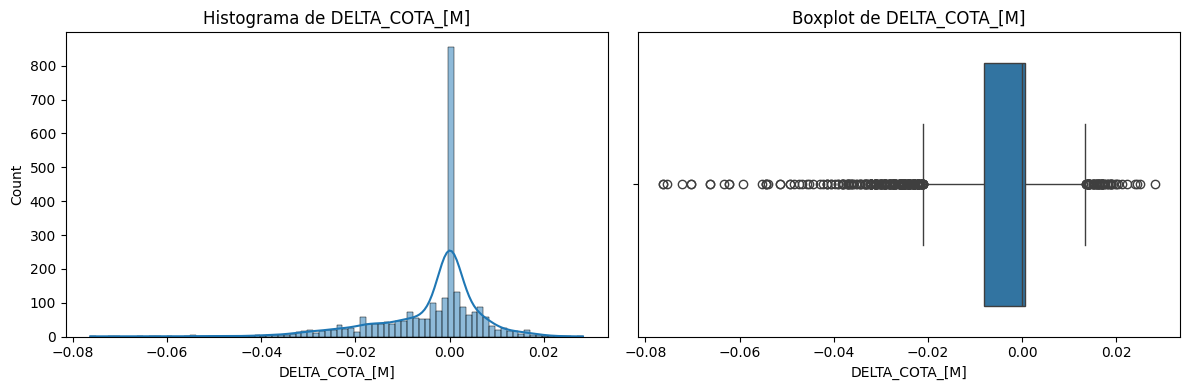

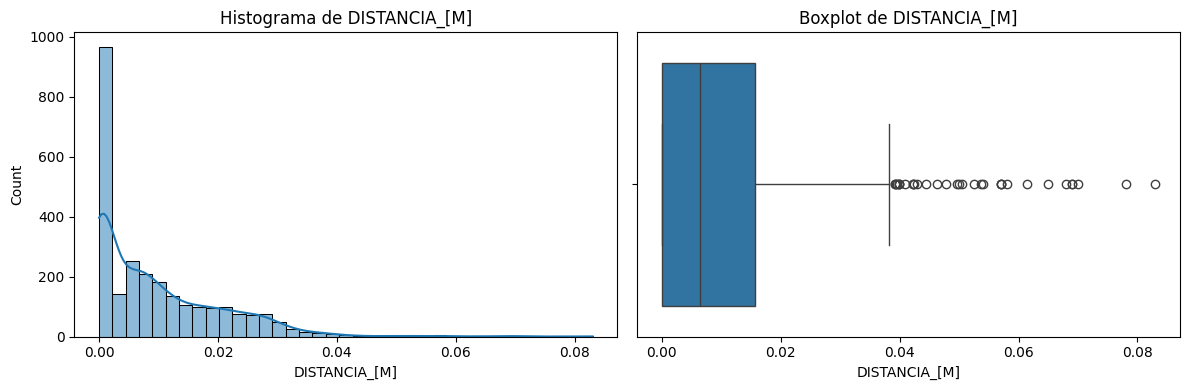

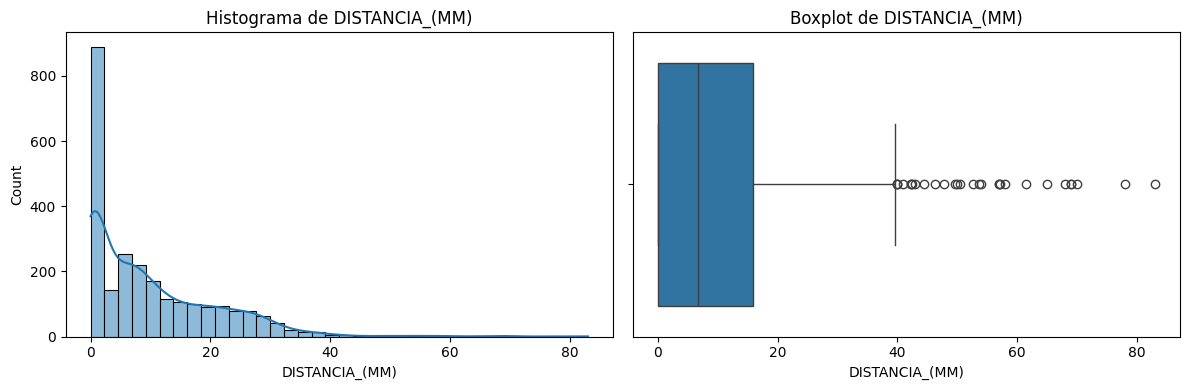

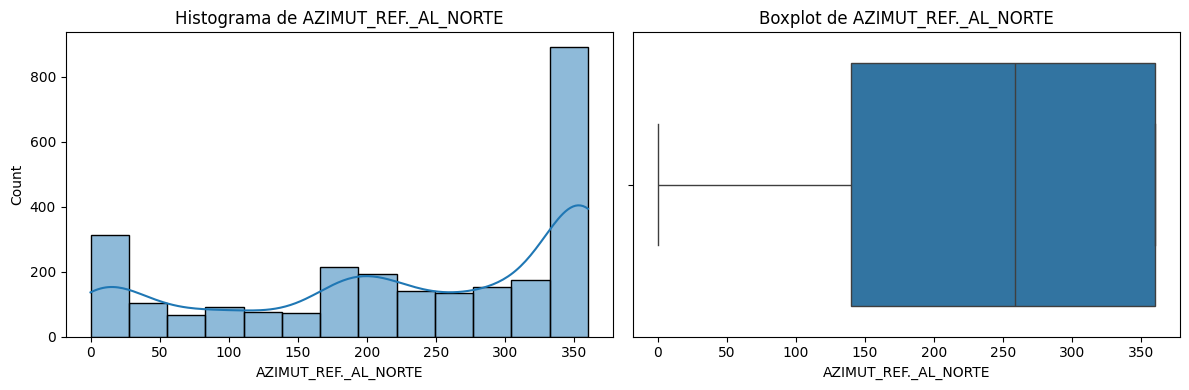

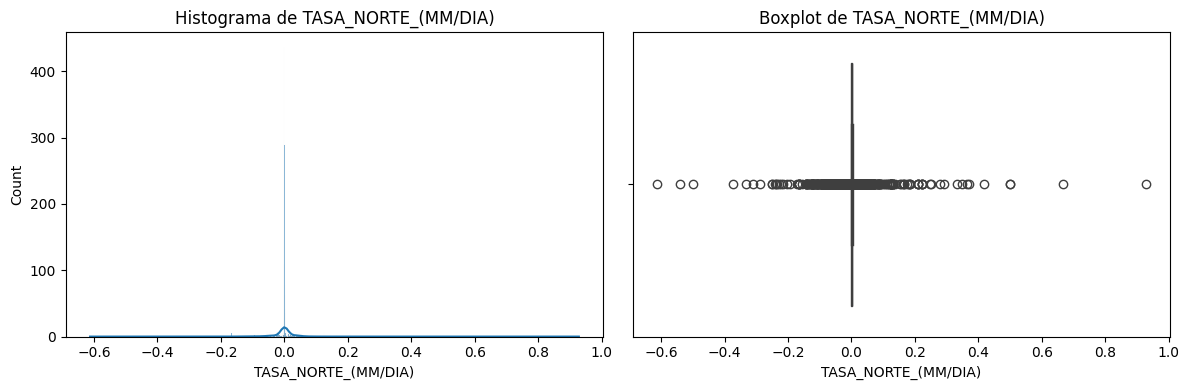

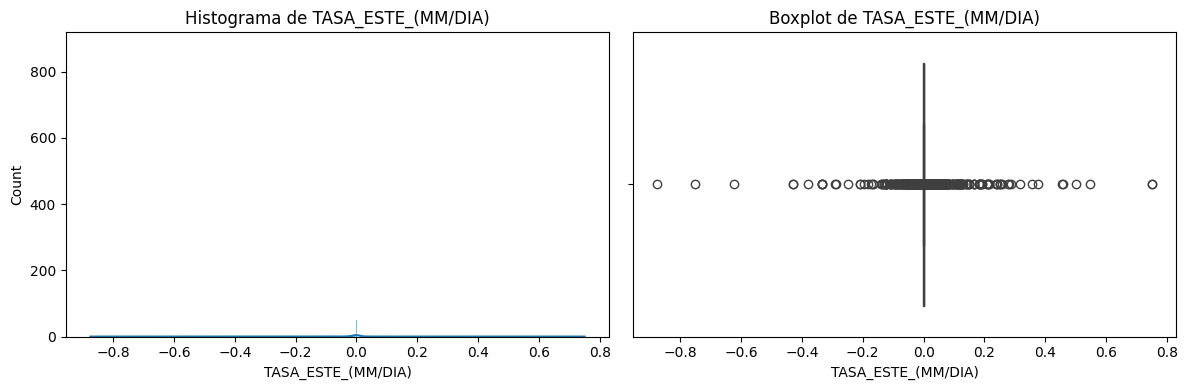

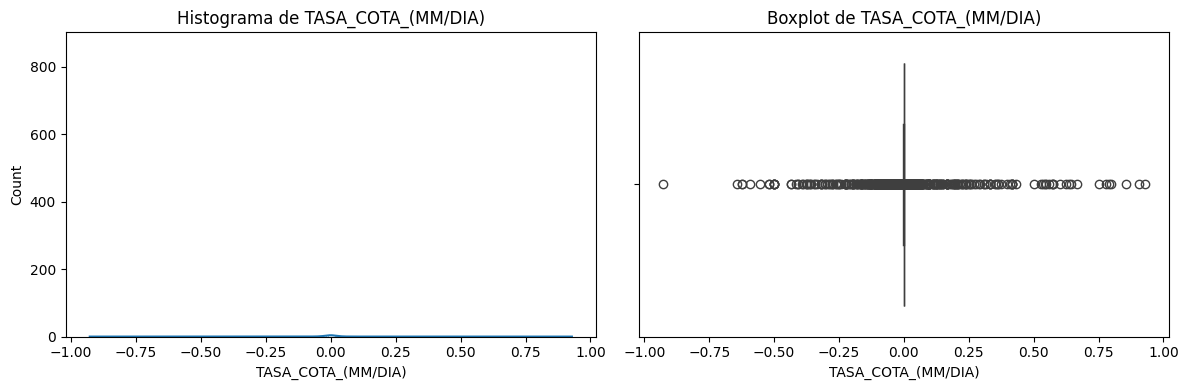

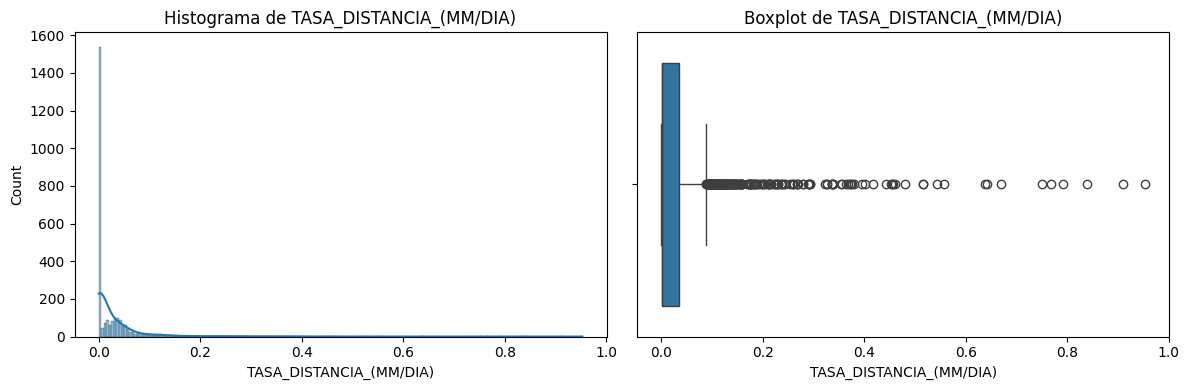

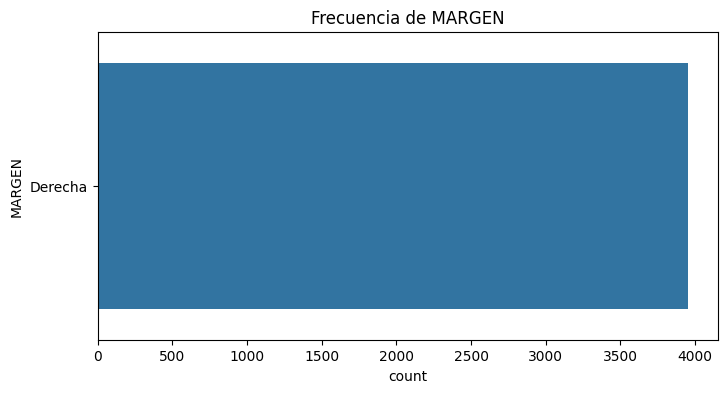

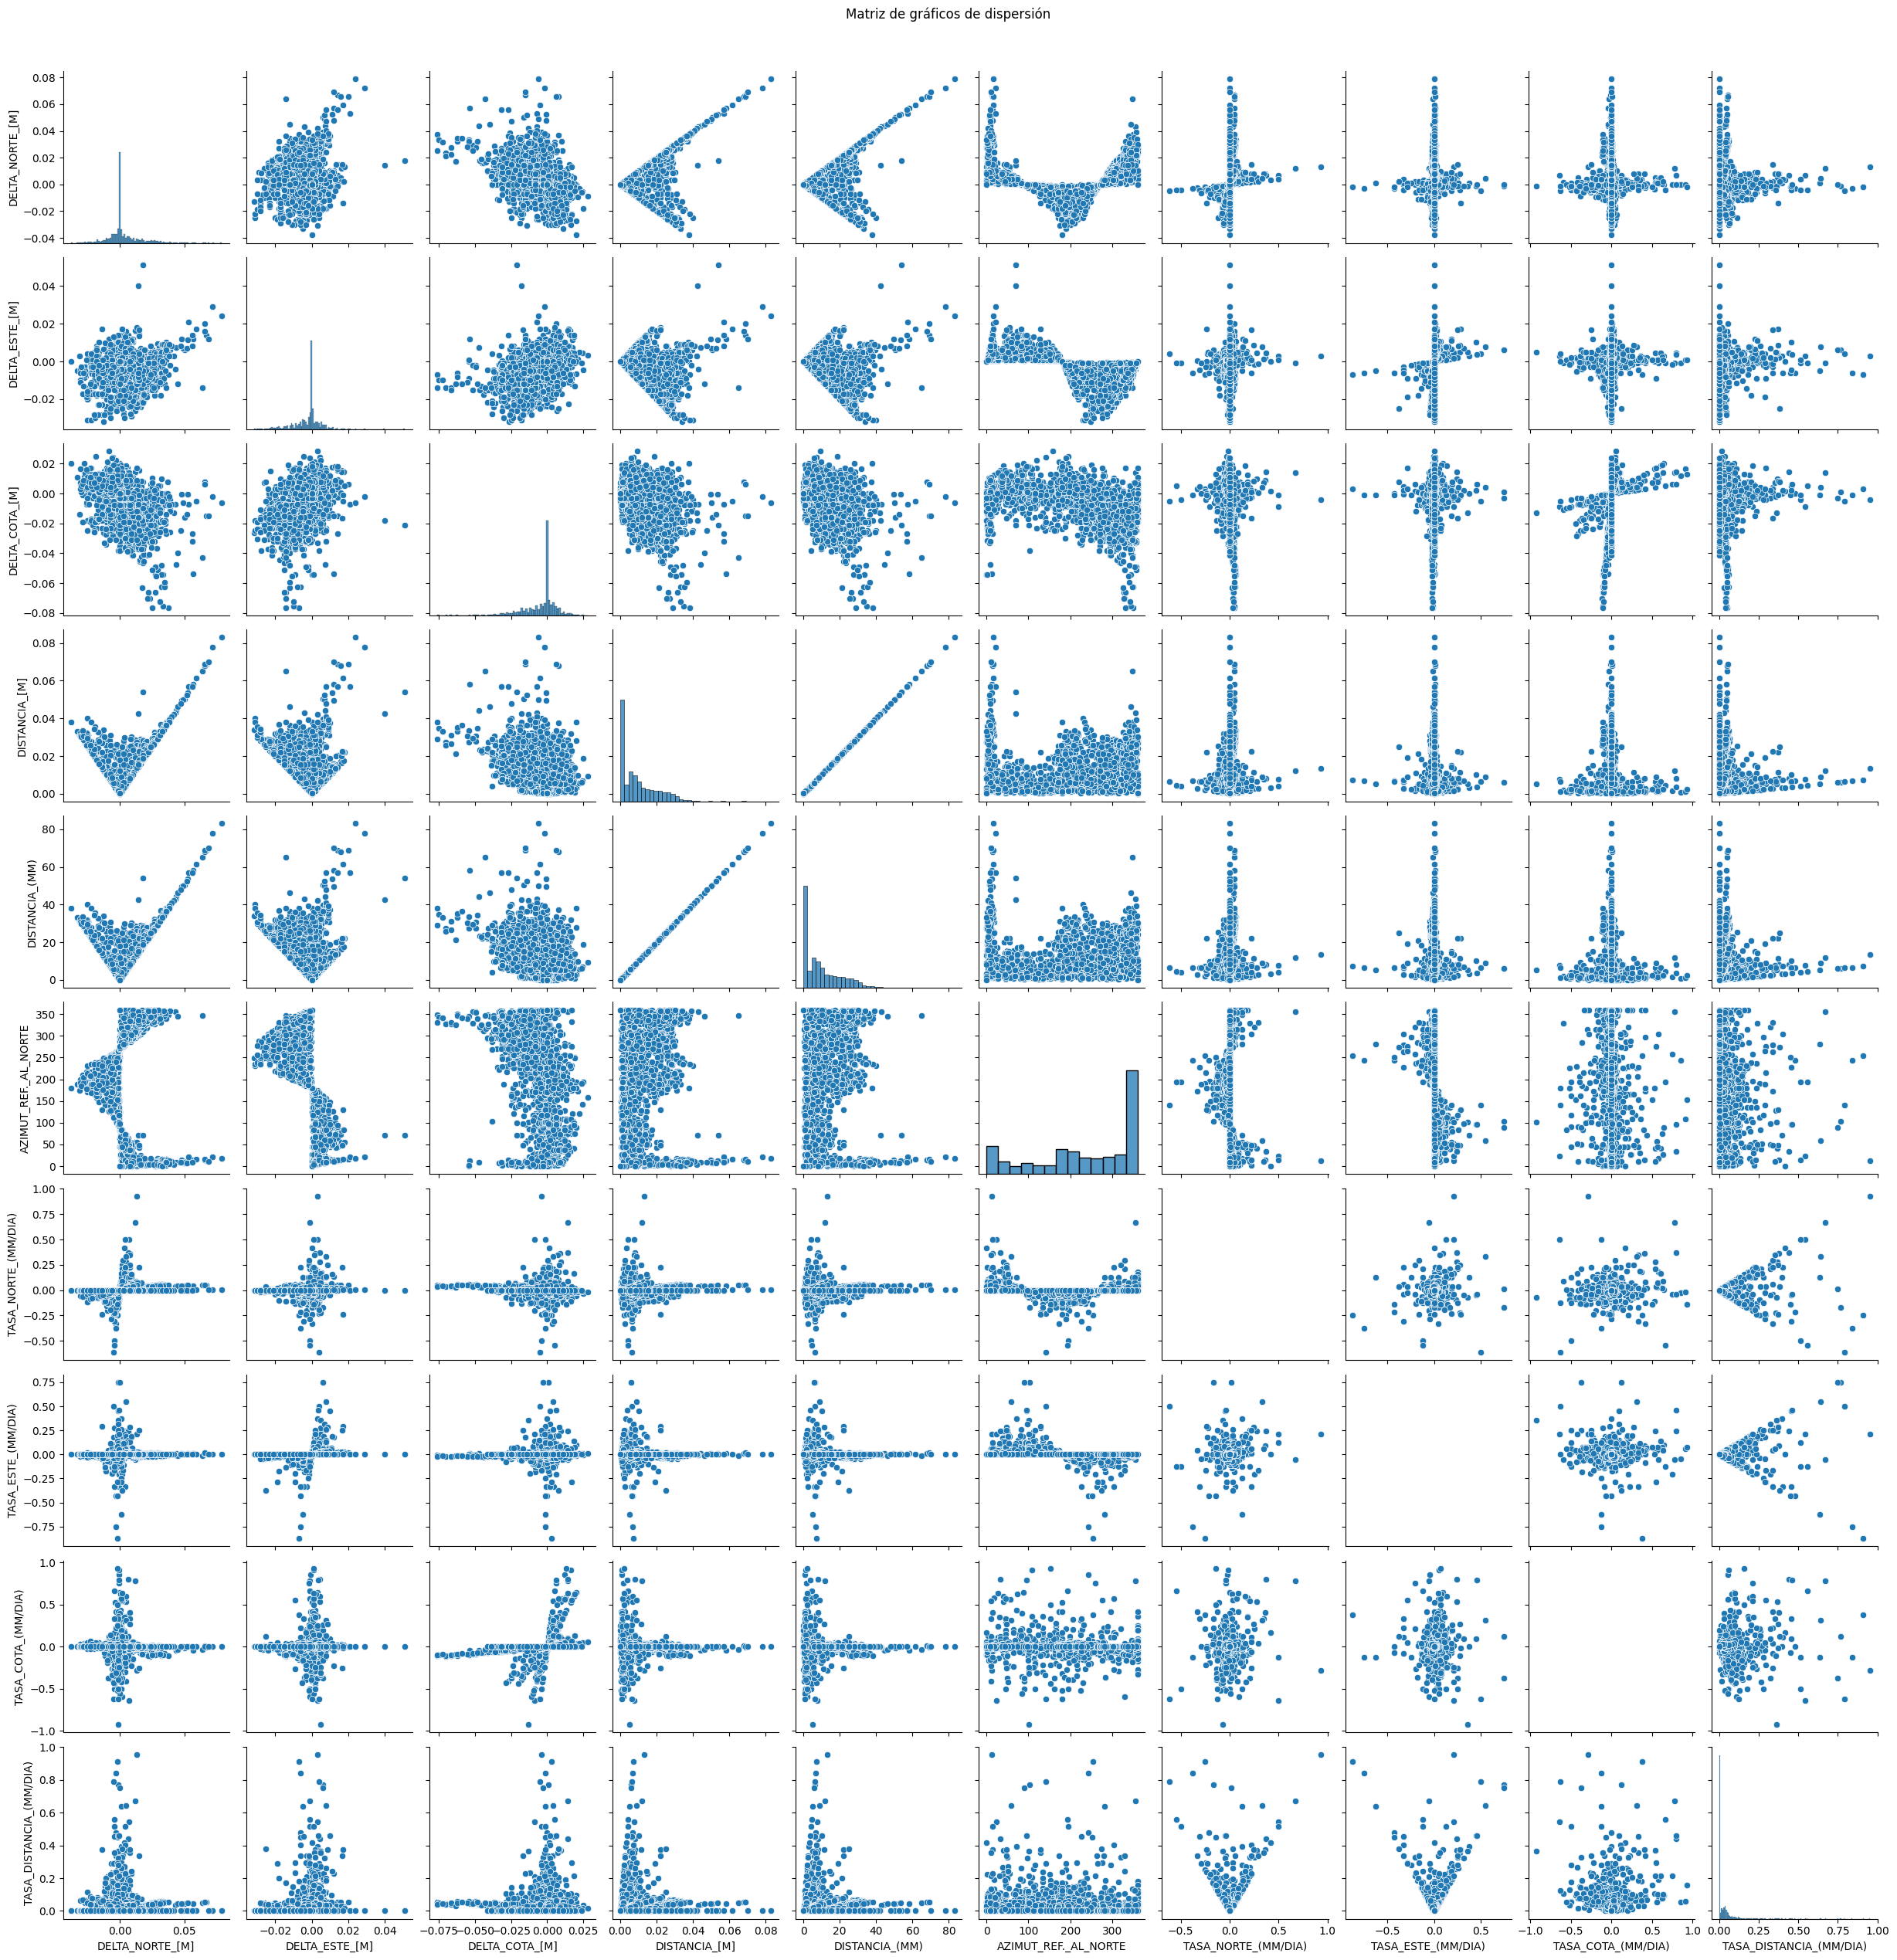

Gráfico de dispersión interactivo con Plotly:



--- Fin de la visualización avanzada ---


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Opcional: plotly express para gráficos interactivos
try:
    import plotly.express as px
    PLOTLY = True
except ImportError:
    PLOTLY = False

try:
    df
except NameError:
    print("❌ La variable 'df' no está definida. Por favor, ejecuta primero la carga y limpieza de datos.")
else:
    print("=== VISUALIZACIÓN AVANZADA DE DATOS ===\n")

    # Histogramas y boxplots para numéricas
    num_cols = df.select_dtypes(include='number').columns
    if len(num_cols) > 0:
        for col in num_cols:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
            axes[0].set_title(f"Histograma de {col}")
            sns.boxplot(x=df[col], ax=axes[1])
            axes[1].set_title(f"Boxplot de {col}")
            plt.tight_layout()
            plt.show()

    # Gráficos de barras para categóricas principales
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if df[col].nunique() < 25:
            plt.figure(figsize=(8, 4))
            sns.countplot(data=df, y=col, order=df[col].value_counts().index)
            plt.title(f"Frecuencia de {col}")
            plt.show()

    # Gráficos de dispersión entre variables numéricas (matriz de pares)
    if len(num_cols) > 1:
        sns.pairplot(df[num_cols].dropna())
        plt.suptitle("Matriz de gráficos de dispersión", y=1.02)
        plt.show()

    # Visualización interactiva opcional con Plotly
    if PLOTLY and len(num_cols) > 1:
        print("Gráfico de dispersión interactivo con Plotly:")
        fig = px.scatter_matrix(df, dimensions=num_cols)
        fig.update_traces(diagonal_visible=False)
        fig.show()

    print("\n--- Fin de la visualización avanzada ---")

# Paso 7: Exportación y preparación de datos limpios (archivo Excel)

En este paso se realiza la exportación de los datos procesados y limpios para su uso en otros sistemas, herramientas de análisis, o para resguardo. También se pueden preparar subconjuntos o transformaciones específicas del DataFrame según necesidades del análisis.

## Incluye:

1. **Exportación a formatos comunes**
   - Guardar el DataFrame limpio en archivos XLSX, CSV y/o Parquet.
   - Opción de exportar subconjuntos (por ejemplo, solo columnas seleccionadas o solo filas con ciertos criterios).

2. **Transformaciones adicionales**
   - Conversión de tipos de datos si es necesario (fechas, categóricas, etc.).
   - Creación de columnas derivadas útiles para análisis posteriores.

3. **Resumen del proceso**
   - Registro de cambios principales realizados al set de datos.
   - Notas sobre supuestos o decisiones tomadas en la limpieza.

> Este paso asegura que los datos finales sean reutilizables, auditables y compatibles con tus próximos procesos de análisis o presentación.

In [7]:
%pip install ipywidgets plotly
from google.colab import output as colab_output
colab_output.enable_custom_widget_manager()

In [8]:
%pip install -U kaleido

In [9]:
import pandas as pd

try:
    import plotly.graph_objects as go
    import plotly.colors as pc
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    import importlib.util
    import os
except ImportError:
    raise ImportError("Ejecuta: pip install plotly ipywidgets")

try:
    df
except NameError:
    print("❌ La variable 'df' no está definida. Por favor, ejecuta primero la carga de datos.")
else:
    df['FECHA'] = pd.to_datetime(df['FECHA'], dayfirst=True, errors='coerce')
    columnas_excluidas = ['FECHA', 'INSTRUMENTO', 'MARGEN']
    variables = [col for col in df.select_dtypes(include='number').columns if col not in columnas_excluidas]
    puntos_fijos = sorted(df['INSTRUMENTO'].dropna().unique())
    opciones_puntos = ["Todos"] + list(puntos_fijos)

    anios = sorted(df['FECHA'].dt.year.dropna().unique())
    opciones_anios = ["Todos"] + [str(a) for a in anios]

    estilos_grafico = [
        "Curvas suaves (spline)",
        "Líneas rectas",
        "Puntos",
        "Líneas + Puntos",
        "Área apilada",
        "Área + Líneas",
        "Área + Líneas + Puntos"
    ]

    tamanios_imagen = {
        "Pequeño (600x400)": (600, 400),
        "Mediano (900x500)": (900, 500),
        "Grande (1200x700)": (1200, 700),
        "Extra grande (1600x1000)": (1600, 1000)
    }

    grosores = {
        "Fino (1px)": 1,
        "Normal (2px)": 2,
        "Medio (4px)": 4,
        "Grueso (7px)": 7,
        "Extra grueso (10px)": 10
    }

    paletas = {
        "Plotly": pc.qualitative.Plotly,
        "D3": pc.qualitative.D3,
        "Viridis": pc.sequential.Viridis,
        "Cividis": pc.sequential.Cividis,
        "Inferno": pc.sequential.Inferno,
        "Pastel": pc.qualitative.Pastel,
        "Bold": pc.qualitative.Bold,
        "Set1": pc.qualitative.Set1,
        "Dark2": pc.qualitative.Dark2
    }

    punto_dropdown = widgets.Dropdown(
        options=opciones_puntos,
        value="Todos",
        description="Punto Fijo:"
    )
    variable_dropdown = widgets.Dropdown(options=variables, description="Variable:")
    estilo_dropdown = widgets.Dropdown(
        options=estilos_grafico,
        value="Curvas suaves (spline)",
        description="Estilo gráfica:"
    )
    anio_dropdown = widgets.Dropdown(
        options=opciones_anios,
        value="Todos",
        description="Año:"
    )
    tamanio_dropdown = widgets.Dropdown(
        options=list(tamanios_imagen.keys()),
        value="Mediano (900x500)",
        description="Tamaño:"
    )
    grosor_dropdown = widgets.Dropdown(
        options=list(grosores.keys()),
        value="Normal (2px)",
        description="Grosor línea:"
    )
    paleta_dropdown = widgets.Dropdown(
        options=list(paletas.keys()),
        value="Plotly",
        description="Paleta colores:"
    )
    boton = widgets.Button(description="Graficar", button_style="success")
    output = widgets.Output()

    # ---------- BLOQUE PARA GUARDAR LA GRÁFICA -------------
    formatos = {
        "PNG": ".png",
        "JPEG": ".jpg",
        "SVG": ".svg",
        "PDF": ".pdf",
        "HTML": ".html"
    }

    formato_dropdown = widgets.Dropdown(
        options=list(formatos.keys()),
        value="PNG",
        description="Formato:"
    )
    ruta_text = widgets.Text(
        value="grafica_exportada",
        description="Ruta y nombre:",
        placeholder="ej: ./carpeta/mi_grafica"
    )
    boton_guardar = widgets.Button(
        description="Guardar gráfica",
        button_style="info"
    )
    output_guardar = widgets.Output()

    def guardar_grafica(b=None):
        with output_guardar:
            clear_output(wait=True)
            ext = formatos[formato_dropdown.value]
            ruta_archivo = ruta_text.value
            if not ruta_archivo.lower().endswith(ext):
                ruta_archivo += ext
            if 'fig' not in globals() or not isinstance(fig, go.Figure):
                print("❌ Primero debes generar una gráfica.")
                return
            try:
                if formato_dropdown.value in ["PNG", "JPEG", "SVG", "PDF"]:
                    if importlib.util.find_spec("kaleido") is None:
                        print("❌ Para guardar como imagen/vector/pdf, instala 'kaleido':\n%pip install -U kaleido")
                        return
                    fig.write_image(ruta_archivo, format=formato_dropdown.value.lower())
                elif formato_dropdown.value == "HTML":
                    fig.write_html(ruta_archivo)
                else:
                    print("❌ Tipo de archivo no soportado.")
                    return
            except Exception as e:
                print("❌ Error al guardar la gráfica:", e)
                return

            print(f"✅ Gráfica guardada en: {os.path.abspath(ruta_archivo)}")
            if os.path.exists(ruta_archivo):
                if 'google.colab' in str(get_ipython()):
                    from google.colab import files
                    files.download(ruta_archivo)
                else:
                    ruta_abs = os.path.abspath(ruta_archivo)
                    display(HTML(f'<a href="file://{ruta_abs}" target="_blank">Descargar archivo</a>'))

    boton_guardar.on_click(guardar_grafica)
    controles_guardar = widgets.HBox([formato_dropdown, ruta_text, boton_guardar])

    # ---------- FIN BLOQUE GUARDADO ------------------------

    def graficar(b=None):
        global fig
        with output:
            clear_output(wait=True)
            variable = variable_dropdown.value
            estilo = estilo_dropdown.value
            punto = punto_dropdown.value
            anio = anio_dropdown.value
            ancho, alto = tamanios_imagen[tamanio_dropdown.value]
            grosor = grosores[grosor_dropdown.value]
            paleta = paletas[paleta_dropdown.value]

            df_plot = df.dropna(subset=['FECHA', 'INSTRUMENTO', variable])

            if anio != "Todos":
                df_plot = df_plot[df_plot['FECHA'].dt.year == int(anio)]
            if punto != "Todos":
                df_plot = df_plot[df_plot['INSTRUMENTO'] == punto]
            if df_plot.empty:
                print("No hay datos para graficar con la selección actual.")
                return

            fig = go.Figure()
            instrumentos = sorted(df_plot['INSTRUMENTO'].unique())
            color_map = {pf: paleta[i % len(paleta)] for i, pf in enumerate(instrumentos)}
            for pf in instrumentos:
                data_pf = df_plot[df_plot['INSTRUMENTO'] == pf]
                line_args = dict(width=grosor, color=color_map[pf])
                marker_args = dict(color=color_map[pf])
                if estilo == "Curvas suaves (spline)":
                    fig.add_trace(go.Scatter(
                        x=data_pf['FECHA'],
                        y=data_pf[variable],
                        mode="lines",
                        name=pf,
                        line_shape="spline",
                        line=line_args
                    ))
                elif estilo == "Líneas rectas":
                    fig.add_trace(go.Scatter(
                        x=data_pf['FECHA'],
                        y=data_pf[variable],
                        mode="lines",
                        name=pf,
                        line_shape="linear",
                        line=line_args
                    ))
                elif estilo == "Puntos":
                    fig.add_trace(go.Scatter(
                        x=data_pf['FECHA'],
                        y=data_pf[variable],
                        mode="markers",
                        name=pf,
                        marker=marker_args
                    ))
                elif estilo == "Líneas + Puntos":
                    fig.add_trace(go.Scatter(
                        x=data_pf['FECHA'],
                        y=data_pf[variable],
                        mode="lines+markers",
                        name=pf,
                        line_shape="linear",
                        line=line_args,
                        marker=marker_args
                    ))
                elif estilo == "Área apilada":
                    fig.add_trace(go.Scatter(
                        x=data_pf['FECHA'],
                        y=data_pf[variable],
                        mode="lines",
                        name=pf,
                        stackgroup='one',
                        line_shape="linear",
                        line=line_args,
                        marker=marker_args
                    ))
                elif estilo == "Área + Líneas":
                    fig.add_trace(go.Scatter(
                        x=data_pf['FECHA'],
                        y=data_pf[variable],
                        mode="lines",
                        name=pf,
                        fill="tozeroy",
                        line_shape="linear",
                        line=line_args,
                        marker=marker_args
                    ))
                elif estilo == "Área + Líneas + Puntos":
                    fig.add_trace(go.Scatter(
                        x=data_pf['FECHA'],
                        y=data_pf[variable],
                        mode="lines+markers",
                        name=pf,
                        fill="tozeroy",
                        line_shape="linear",
                        line=line_args,
                        marker=marker_args
                    ))

            fig.update_layout(
                width=ancho,
                height=alto,
                title=f"{variable} en función del tiempo por Punto Fijo (PF)",
                xaxis_title="Fecha",
                yaxis_title=variable,
                legend_title="INSTRUMENTO",
                hovermode="x unified"
            )
            fig.show()

    # Selectores arriba, botón abajo
    selectores = widgets.HBox([
        punto_dropdown, variable_dropdown, estilo_dropdown, anio_dropdown,
        tamanio_dropdown, grosor_dropdown, paleta_dropdown
    ])
    controls = widgets.VBox([
        selectores,
        boton
    ])

    display(controls, output, controles_guardar, output_guardar)
    boton.on_click(graficar)

Output()

Output()

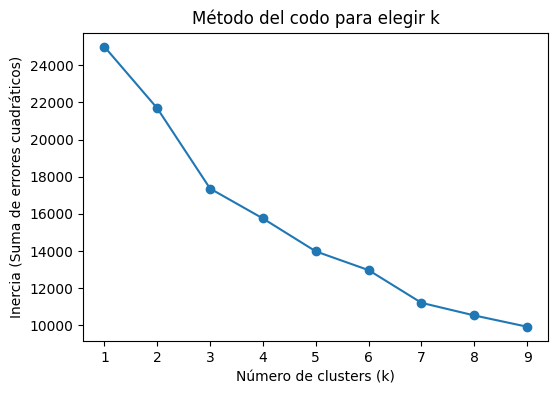

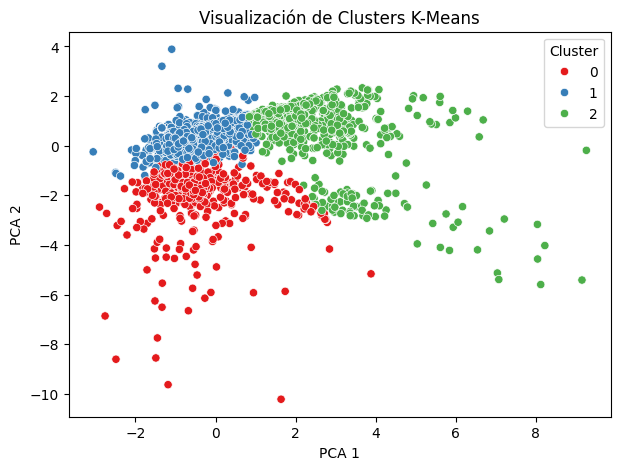

DELTA_NORTE_[M]  DELTA_ESTE_[M]  DELTA_COTA_[M]  DISTANCIA_[M]  \
Cluster                                                                   
0               0.004278        0.004669        0.000259       0.008489   
1              -0.002655       -0.001742       -0.000459       0.004822   
2               0.015359       -0.009806       -0.018586       0.024610   

         DISTANCIA_(MM)  AZIMUT_REF._AL_NORTE  TASA_NORTE_(MM/DIA)  \
Cluster                                                              
0              8.488986             61.655928             0.020272   
1              4.822177            287.550272            -0.011210   
2             24.610419            264.004079             0.009123   

         TASA_ESTE_(MM/DIA)  TASA_COTA_(MM/DIA)  TASA_DISTANCIA_(MM/DIA)  
Cluster                                                                   
0                  0.043278            0.017480                 0.067275  
1                 -0.011055           -0.003235                 0.025790  
2                 -0.005665           -0.012020                 0.014061

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Selecciona solo variables numéricas relevantes (puedes ajustar columnas)
columnas_excluidas = ['FECHA', 'INSTRUMENTO', 'MARGEN']
variables = [col for col in df.select_dtypes(include='number').columns if col not in columnas_excluidas]
datos_cluster = df[variables].dropna()

# Estandariza los datos para clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(datos_cluster)

# Elige número de clusters con método del codo
inertia = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de errores cuadráticos)')
plt.title('Método del codo para elegir k')
plt.show()

# Elige k óptimo (por ejemplo, 3)
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df['Cluster'] = None  # Evita errores si ya existe la columna
df.loc[datos_cluster.index, 'Cluster'] = labels

# Visualiza los clusters en las primeras dos variables principales
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='Set1')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualización de Clusters K-Means")
plt.legend(title='Cluster')
plt.show()

# Agrupa y observa medias por cluster
display(df.groupby('Cluster')[variables].mean())

In [16]:
print(df.columns.tolist())

['FECHA', 'MARGEN', 'INSTRUMENTO', 'DELTA_NORTE_[M]', 'DELTA_ESTE_[M]', 'DELTA_COTA_[M]', 'DISTANCIA_[M]', 'DISTANCIA_(MM)', 'AZIMUT_REF._AL_NORTE', 'TASA_NORTE_(MM/DIA)', 'TASA_ESTE_(MM/DIA)', 'TASA_COTA_(MM/DIA)', 'TASA_DISTANCIA_(MM/DIA)', 'Cluster']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n888a3p/1_d4a7et.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n888a3p/_8ge6ihb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3507', 'data', 'file=/tmp/tmp_n888a3p/1_d4a7et.json', 'init=/tmp/tmp_n888a3p/_8ge6ihb.json', 'output', 'file=/tmp/tmp_n888a3p/prophet_modelt8eexh_b/prophet_model-20250611010840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:08:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


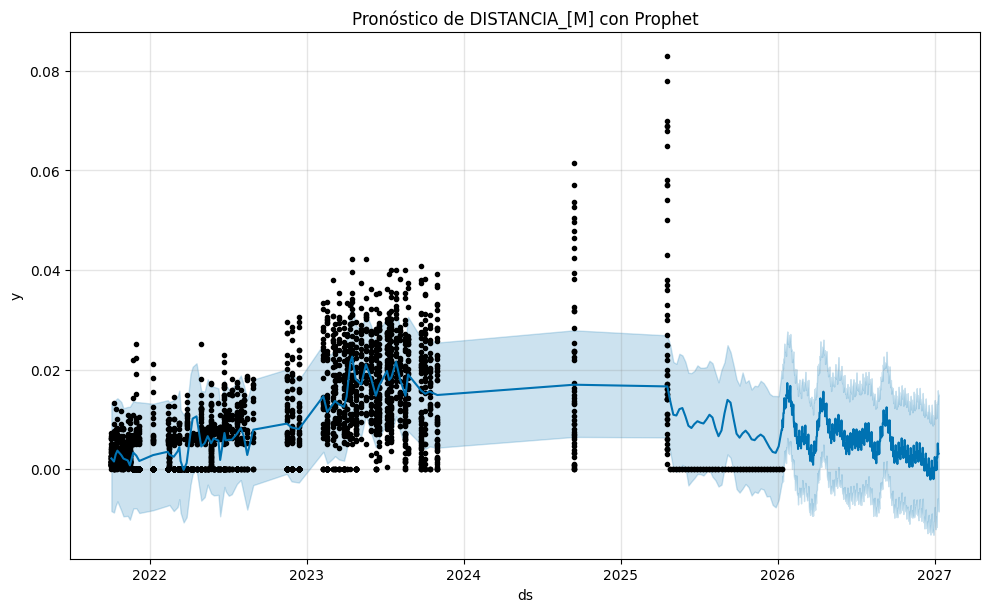

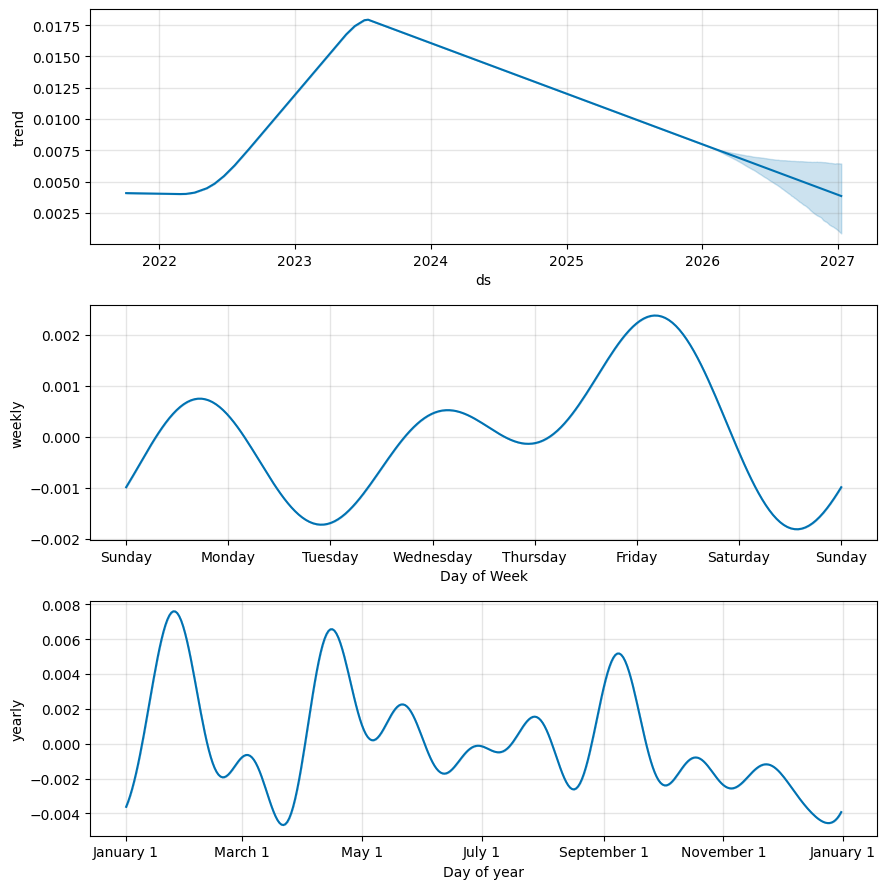

In [17]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Elige la variable a predecir (usa uno de estos nombres exactos)
variable_pred = 'DISTANCIA_[M]'  # Cambia aquí si prefieres otra

# Prepara los datos para Prophet
df_prophet = df[['FECHA', variable_pred]].dropna().rename(columns={'FECHA': 'ds', variable_pred: 'y'})

# Si tu columna 'FECHA' no es tipo datetime, conviértela:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Crea y ajusta el modelo
modelo = Prophet()
modelo.fit(df_prophet)

# Genera fechas futuras para predecir (ejemplo: 365 días)
futuro = modelo.make_future_dataframe(periods=365, freq='D')
pronostico = modelo.predict(futuro)

# Visualiza resultado
fig1 = modelo.plot(pronostico)
plt.title(f"Pronóstico de {variable_pred} con Prophet")
plt.show()

# Componentes de tendencia y estacionalidad
fig2 = modelo.plot_components(pronostico)
plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from ipywidgets import Dropdown, Button, VBox, Output

# Asegúrate de que 'FECHA' sea tipo datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Lista de variables numéricas (excepto 'Cluster')
variables_numericas = [
    col for col in df.select_dtypes(include='number').columns
    if col != 'Cluster'
]

# Crea widgets
dropdown = Dropdown(
    options=variables_numericas,
    description='Variable:',
    value=variables_numericas[0]
)
button = Button(description='Generar Pronóstico')
out = Output()

def generar_pronostico(b):
    out.clear_output()
    variable = dropdown.value
    # Prepara datos
    df_prophet = df[['FECHA', variable]].dropna().rename(
        columns={'FECHA': 'ds', variable: 'y'}
    )
    # Prophet
    modelo = Prophet()
    modelo.fit(df_prophet)
    futuro = modelo.make_future_dataframe(periods=365, freq='D')
    pronostico = modelo.predict(futuro)
    # Graficar
    with out:
        fig1 = modelo.plot(pronostico)
        plt.title(f"Pronóstico de {variable} con Prophet")
        plt.show()
        fig2 = modelo.plot_components(pronostico)
        plt.show()

button.on_click(generar_pronostico)

# Muestra la interfaz
display(VBox([dropdown, button, out]))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n888a3p/bmks1cuc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n888a3p/523md6ux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46413', 'data', 'file=/tmp/tmp_n888a3p/bmks1cuc.json', 'init=/tmp/tmp_n888a3p/523md6ux.json', 'output', 'file=/tmp/tmp_n888a3p/prophet_modelk7s4763h/prophet_model-20250611011035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:10:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:10:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, Button, VBox, Output, IntSlider
from statsmodels.tsa.arima.model import ARIMA

# Asegúrate que 'FECHA' sea datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Variables numéricas
variables_numericas = [
    col for col in df.select_dtypes(include='number').columns
    if col != 'Cluster'
]

# Widgets
dropdown = Dropdown(
    options=variables_numericas,
    description='Variable:',
    value=variables_numericas[0]
)
slider = IntSlider(value=365, min=30, max=1095, step=30, description='Días futuros')
button = Button(description='Generar Pronóstico')
out = Output()

def generar_pronostico_arima(b):
    out.clear_output()
    variable = dropdown.value
    dias = slider.value
    # Prepara la serie
    serie = df[['FECHA', variable]].dropna().set_index('FECHA').sort_index()
    # ARIMA simple (p=1,d=1,q=1), puedes tunear según tus datos
    with out:
        try:
            modelo = ARIMA(serie, order=(1,1,1))
            modelo_fit = modelo.fit()
            pred = modelo_fit.get_forecast(steps=dias)
            pred_ci = pred.conf_int()
            # Graficar
            plt.figure(figsize=(10,5))
            plt.plot(serie, label='Histórico')
            plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Pronóstico')
            plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=0.2)
            plt.title(f'Pronóstico ARIMA para {variable}')
            plt.legend()
            plt.show()
        except Exception as e:
            print(f'Ocurrió un error: {e}')

button.on_click(generar_pronostico_arima)
display(VBox([dropdown, slider, button, out]))

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, Button, VBox, Output, IntSlider
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df['FECHA'] = pd.to_datetime(df['FECHA'])
variables_numericas = [col for col in df.select_dtypes(include='number').columns if col != 'Cluster']

dropdown = Dropdown(options=variables_numericas, description='Variable:', value=variables_numericas[0])
slider = IntSlider(value=365, min=30, max=365, step=30, description='Días futuros')
button = Button(description='Generar Pronóstico')
out = Output()

def generar_pronostico_lstm(b):
    out.clear_output()
    variable = dropdown.value
    dias = slider.value
    serie = df[['FECHA', variable]].dropna().set_index('FECHA').sort_index()
    valores = serie[variable].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    valores_scaled = scaler.fit_transform(valores)
    # Prepara datos para LSTM
    look_back = 30
    X, y = [], []
    for i in range(look_back, len(valores_scaled)):
        X.append(valores_scaled[i-look_back:i, 0])
        y.append(valores_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    # Modelo
    with out:
        try:
            model = Sequential()
            model.add(LSTM(50, input_shape=(look_back, 1)))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')
            model.fit(X, y, epochs=10, batch_size=16, verbose=0)
            # Pronóstico futuro
            pred_input = valores_scaled[-look_back:].reshape(1, look_back, 1)
            preds = []
            for _ in range(dias):
                pred = model.predict(pred_input)[0,0]
                preds.append(pred)
                pred_input = np.append(pred_input[:,1:,:], [[[pred]]], axis=1)
            preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
            fechas_futuras = pd.date_range(serie.index[-1]+pd.Timedelta(days=1), periods=dias, freq='D')
            # Graficar
            plt.figure(figsize=(10,5))
            plt.plot(serie.index, serie[variable], label='Histórico')
            plt.plot(fechas_futuras, preds_inv, label='Pronóstico')
            plt.title(f'Pronóstico LSTM para {variable}')
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Ocurrió un error: {e}")

button.on_click(generar_pronostico_lstm)
display(VBox([dropdown, slider, button, out]))

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, Button, VBox, Output, IntSlider
from sklearn.ensemble import RandomForestRegressor

# Asegúrate que 'FECHA' sea tipo datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Variables numéricas candidatas (excepto 'Cluster')
variables_numericas = [
    col for col in df.select_dtypes(include='number').columns
    if col != 'Cluster'
]

dropdown = Dropdown(
    options=variables_numericas,
    description='Variable:',
    value=variables_numericas[0]
)
slider = IntSlider(value=365, min=30, max=365, step=30, description='Días futuros')
button = Button(description='Generar Pronóstico')
out = Output()

def generar_pronostico_rf(b):
    out.clear_output()
    variable = dropdown.value
    dias = slider.value

    # Prepara la serie temporal con retrasos como features
    serie = df[['FECHA', variable]].dropna().set_index('FECHA').sort_index()
    n_lags = 30  # Número de días pasados como input
    data = []
    for i in range(n_lags, len(serie)):
        data.append(serie[variable].values[i-n_lags:i+1])
    data = np.array(data)
    X = data[:,:-1]
    y = data[:,-1]

    # Entrena modelo
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predicción futura (rolling)
    ultimos = serie[variable].values[-n_lags:]
    predichos = []
    for _ in range(dias):
        x_input = ultimos[-n_lags:]
        pred = model.predict([x_input])[0]
        predichos.append(pred)
        ultimos = np.append(ultimos, pred)

    # Fechas futuras
    fechas_futuras = pd.date_range(serie.index[-1] + pd.Timedelta(days=1), periods=dias, freq='D')

    # Graficar
    with out:
        plt.figure(figsize=(10,5))
        plt.plot(serie.index, serie[variable], label='Histórico')
        plt.plot(fechas_futuras, predichos, label='Pronóstico Random Forest')
        plt.title(f'Pronóstico Random Forest para {variable}')
        plt.legend()
        plt.show()

button.on_click(generar_pronostico_rf)

display(VBox([dropdown, slider, button, out]))